# Glint-FMPair evaluation on Spotify MPD

In [1]:
import os
os.environ["PYSPARK_SUBMIT_ARGS"] = "--conf spark.driver.memory=35G " + \
    "--conf \"spark.driver.extraJavaOptions=-XX:+UseG1GC -XX:InitiatingHeapOccupancyPercent=35 -XX:-ResizePLAB\" " + \
    "--conf spark.driverEnv.LD_PRELOAD=/opt/cloudera/parcels/mkl/linux/mkl/lib/intel64/libmkl_rt.so " + \
    "--conf spark.driverEnv.MKL_VERBOSE=0 " + \
    "--jars glint-fmpair/target/scala-2.11/glint-fmpair-assembly-1.0.jar pyspark-shell"

import pickle
import random
import time

from math import log2, ceil
from matplotlib import pyplot as plt, patches as mpatches

from pyspark.ml.linalg import VectorUDT
from pyspark.ml.feature import VectorAssembler, StringIndexer, RegexTokenizer, \
    StopWordsRemover, CountVectorizer, StringIndexerModel, CountVectorizerModel, Bucketizer
from pyspark.sql.functions import collect_set, udf, col, mean, first, year, lower, \
    explode, explode_outer, lag, to_timestamp, regexp_replace, expr, when, posexplode, \
    lit, count, max as sparkMax, sum as sparkSum, array_remove
from pyspark.sql import SparkSession, Window, Row


from glintfmpair import WeightHotEncoderEstimator, WeightHotEncoderModel, \
    GlintFMPair, GlintFMPairModel, PopRank, SAGH, KNN

In [5]:
spark = SparkSession.builder \
    .appName("Glint-FMPair evaluation on Spotify MPD") \
    .master("yarn") \
    .config("spark.submit.deployMode","client") \
    .config("spark.dynamicAllocation.enabled", "false") \
    .config("spark.executor.memory", "25G") \
    .config("spark.yarn.executor.memoryOverhead", "5G") \
    .config("spark.executor.instances", "80") \
    .config("spark.executor.cores", "5") \
    .config("spark.executor.extraJavaOptions" "-XX:+UseG1GC -XX:InitiatingHeapOccupancyPercent=35 -XX:-ResizePLAB") \
    .config("spark.executorEnv.LD_PRELOAD",
            "/opt/cloudera/parcels/mkl/linux/mkl/lib/intel64/libmkl_rt.so") \
    .config("spark.executorEnv.MKL_VERBOSE", "0") \
    .config("spark.jars", "glint-fmpair/target/scala-2.11/glint-fmpair-assembly-1.0.jar") \
    .config("spark.kryoserializer.buffer.max", "256m") \
    .config("spark.executor.heartbeatInterval", "100000") \
    .config("spark.network.timeout", "1000000") \
    .config("spark.maxRemoteBlockSizeFetchToMem", "256m") \
    .config("spark.driver.maxResultSize", "8G") \
    .config("spark.default.parallelism", "400") \
    .getOrCreate()

sc = spark.sparkContext

In [6]:
spark.udf.registerJavaFunction("resizeVector", "org.apache.spark.ml.recommendation.ResizeVector", VectorUDT())
spark.udf.registerJavaFunction("weighVector", "org.apache.spark.ml.recommendation.WeighVector", VectorUDT())

In [7]:
dataPath = "hdfs:/user/app/2018S/public/recsys_spotify_2018/mpd.v1/mpd.slice.*.json"
albumDataPath = "spotify-albums.csv"
audioDataPath = "spotify-audio.csv"

In [8]:
trans=False
valSplit=False
seedsSplit=True

In [9]:
if seedsSplit:
    if trans:
        indexedTrainDataPath = "MPD-train-trans-seeds.parquet"
        indexedValSeedsDataPath = "MPD-valseeds-trans-seeds.parquet"
        indexedValDataPath = "MPD-val-trans-seeds.parquet"
        indexedValCtxDataPath = "MPD-val-ctx-trans-seeds.parquet"
        indexerModelPathFormat = "MPD-{}-indexer-trans-seeds.model"
        nameEncoderModelPath = "MPD-nameencoder-trans-seeds.model"
        encoderModelPaths = ["MPD-usercoldstartencoder-trans-seeds.model",
                             "MPD-userencoder-trans-seeds.model",
                             "MPD-itemencoder-trans-seeds.model",
                             "MPD-ctxitemencoder-trans-seeds.model"]
    else:
        indexedTrainDataPath = "MPD-train-seeds.parquet"
        indexedValSeedsDataPath = "MPD-valseeds-seeds.parquet"
        indexedValDataPath = "MPD-val-seeds.parquet"
        indexedValCtxDataPath = "MPD-val-ctx-seeds.parquet"
        indexerModelPathFormat = "MPD-{}-indexer-seeds.model"
        nameEncoderModelPath = "MPD-nameencoder-seeds.model"
        encoderModelPaths = ["MPD-usercoldstartencoder-seeds.model",
                             "MPD-userencoder-seeds.model",
                             "MPD-itemencoder-seeds.model",
                             "MPD-ctxitemencoder-seeds.model"]    
elif valSplit:
    if trans:
        indexedTrainDataPath = "MPD-train-trans.parquet"
        indexedValSeedsDataPath = "MPD-valseeds-trans.parquet"
        indexedValDataPath = "MPD-val-trans.parquet"
        indexerModelPathFormat = "MPD-{}-indexer-trans.model"
        nameEncoderModelPath = "MPD-nameencoder-trans.model"
        encoderModelPaths = ["MPD-usercoldstartencoder-trans.model", "MPD-userencoder-trans.model",
                             "MPD-itemencoder-trans.model", "MPD-ctxitemencoder-trans.model"]
    else:
        indexedTrainDataPath = "MPD-train.parquet"
        indexedValSeedsDataPath = "MPD-valseeds.parquet"
        indexedValDataPath = "MPD-val.parquet"
        indexerModelPathFormat = "MPD-{}-indexer.model"
        nameEncoderModelPath = "MPD-nameencoder.model"
        encoderModelPaths = ["MPD-usercoldstartencoder.model", "MPD-userencoder.model",
                             "MPD-itemencoder.model", "MPD-ctxitemencoder.model"]
else:
    if trans:
        indexedTrainDataPath = "MPD-test-train-trans.parquet"
        indexedValSeedsDataPath = "MPD-test-valseeds-trans.parquet"
        indexedValDataPath = "MPD-val-test-trans.parquet"
        indexerModelPathFormat = "MPD-test-{}-indexer-trans.model"
        nameEncoderModelPath = "MPD-test-nameencoder-trans.model"
        encoderModelPaths = ["MPD-test-usercoldstartencoder-trans.model", "MPD-test-userencoder-trans.model",
                             "MPD-test-itemencoder-trans.model", "MPD-test-ctxitemencoder-trans.model"]
    else:
        indexedTrainDataPath = "MPD-test-train.parquet"
        indexedValSeedsDataPath = "MPD-test-valseeds.parquet"
        indexedValDataPath = "MPD-test-val.parquet"
        indexerModelPathFormat = "MPD-test-{}-indexer.model"
        nameEncoderModelPath = "MPD-test-nameencoder.model"
        encoderModelPaths = ["MPD-test-usercoldstartencoder.model", "MPD-test-userencoder.model",
                             "MPD-test-itemencoder.model", "MPD-test-ctxitemencoder.model"]

In [10]:
parameterServerHost="10.7.0.117"

In [11]:
loadFeatures=False
saveFeatures=False
loadIndexed=True
saveIndexed=False

loadIndexers=True
saveIndexers=False
loadNameEncoder=True
saveNameEncoder=False
loadEncoders=True
saveEncoders=False

## Data loading

In [12]:
def loadData(s, dataPath): 
    return s.read.option("multiLine", "true").json(dataPath) \
        .select(explode(col("playlists")).alias("playlist")) \
        .select("playlist.pid", "playlist.name", "playlist.modified_at", "playlist.tracks") \
        .select(col("pid").cast("integer"), \
                lower(col("name")).alias("name"), \
                year(to_timestamp("modified_at")).alias("modified_at_year"), \
                explode_outer(col("tracks")).alias("track")) \
        .select("pid", "name", "modified_at_year", \
                "track.track_uri", "track.album_uri", "track.artist_uri", "track.pos") \
        .select("pid", "name", "modified_at_year", "pos", \
                regexp_replace("track_uri", "spotify:track:", "").alias("track_uri"), \
                regexp_replace("album_uri", "spotify:album:", "").alias("album_uri"), \
                regexp_replace("artist_uri", "spotify:artist:", "").alias("artist_uri"))


def withAlbumData(df, s, dataPath):
    albumDf = s.read.option("header", "true").csv(dataPath) \
        .select(col("id").alias("album_uri"), col("release_date").substr(0, 4).alias("release_date"))
    return df.join(albumDf, "album_uri", how="left")


def withAudioData(df, s, dataPath):
    audioDf = s.read.option("header", "true").csv(dataPath).select(
        col("id").alias("track_uri"),
        col("danceability").cast("double").alias("danceability"),
        col("energy").cast("double").alias("energy"),
        col("valence").cast("double").alias("valence"),
        col("acousticness").cast("double").alias("acousticness"),
        when(col("key") == -1, 12).otherwise(col("key")).cast("integer").alias("keyid"),
        col("loudness").cast("double").alias("loudness"),
        col("mode").cast("integer").alias("modeid"),  # TODO: rerun
        col("tempo").cast("double").alias("tempo"))
    
    return df.join(audioDf, "track_uri", how="left") \
        .fillna(12, subset=["keyid"]) \
        .fillna(2, subset=["modeid"])


def withPrevData(df):
    prevWindow = Window.partitionBy("pid").orderBy("pos")
    return df \
        .withColumn("prev_track_uri", lag("track_uri", 1).over(prevWindow)) \
        .withColumn("prev_album_uri", lag("album_uri", 1).over(prevWindow)) \
        .withColumn("prev_artist_uri", lag("artist_uri", 1).over(prevWindow)) \
        .withColumn("prev_release_date", lag("release_date", 1).over(prevWindow)) \
        .withColumn("prev_danceability", lag("danceability", 1).over(prevWindow)) \
        .withColumn("prev_energy", lag("energy", 1).over(prevWindow)) \
        .withColumn("prev_valence", lag("valence", 1).over(prevWindow)) \
        .withColumn("prev_acousticness", lag("acousticness", 1).over(prevWindow)) \
        .withColumn("prev_keyid", lag("keyid", 1).over(prevWindow)) \
        .withColumn("prev_loudness", lag("loudness", 1).over(prevWindow)) \
        .withColumn("prev_modeid", lag("modeid", 1).over(prevWindow)) \
        .withColumn("prev_tempo", lag("tempo", 1).over(prevWindow)) \
        .fillna(12, subset=["prev_keyid"]) \
        .fillna(2, subset=["prev_modeid"])


if not loadFeatures and not loadIndexed:
    data = loadData(spark, dataPath)
    data = withAlbumData(data, spark, albumDataPath)
    data = withAudioData(data, spark, audioDataPath)
    data = withPrevData(data)
    if not seedsSplit and trans:
        data = data.where(col("pos") != 0)

In [31]:
data.count()

66350223

In [14]:
data.select("pid").dropDuplicates().count()

1000000

In [15]:
data.select("track_uri").dropDuplicates().count()

2262292

In [16]:
data.select("album_uri").dropDuplicates().count()

734684

In [18]:
data.select("artist_uri").dropDuplicates().count()

295860

In [21]:
trackCountsDf = data.select("pid", "track_uri") \
    .groupBy("pid") \
    .agg(count("track_uri").alias("count")) \
    .select("count")

trackCountsDf.select(mean("count").alias("average playlist length")).show()

+-----------------------+
|average playlist length|
+-----------------------+
|              66.350223|
+-----------------------+



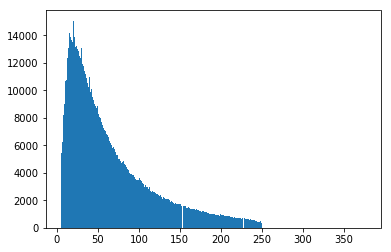

In [27]:
trackCounts = trackCountsDf.rdd.map(lambda r: r[0]).collect()
plt.hist(trackCounts, bins=max(trackCounts));

In [28]:
playlistCountsDf = data.select("pid", "track_uri") \
    .groupBy("track_uri") \
    .agg(count("pid").alias("count")) \
    .select("count")

playlistCountsDf.select(mean("count").alias("average playlists per track")).show()

+---------------------------+
|average playlists per track|
+---------------------------+
|         29.328761715994222|
+---------------------------+



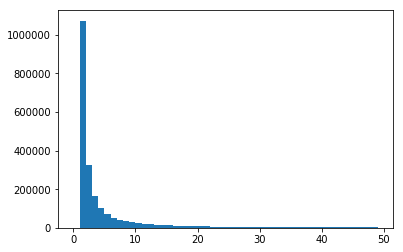

In [32]:
playlistCounts = playlistCountsDf.rdd.map(lambda r: r[0]).collect()
plt.hist(playlistCounts, bins=range(0, 50));

## Evaluation split

In [13]:
if not loadFeatures and not loadIndexed:
    random.seed(1)
    testPids = [random.randint(0, 1000000) for i in range(1000)]

def trainTestSplit(data):
    train = data.where(~col("pid").isin(testPids))
    test = data.where(col("pid").isin(testPids))
    return train, test


def seedsCtxSplit(data):
    maxPosWindow = sparkMax("pos").over(Window.partitionBy("pid"))
    data = data.withColumn("maxPos", maxPosWindow)
    seeds = data.where(col("pos") < col("maxPos")).drop("maxPos")
    context = data.where(col("pos") == col("maxPos")).drop("maxPos")
    return seeds, context


def posSplit(data, splitPos):
    ltSplit = data.where(col("pos") < splitPos)
    geSplit = data.where(col("pos") >= splitPos)
    return ltSplit, geSplit
                

def lastTrackSplit(data, valSplit=False):
    train, test = trainTestSplit(data)
    testSeeds, test = seedsCtxSplit(test)
    if valSplit:
        valSeeds, val = seedsCtxSplit(testSeeds)
        return train.unionAll(valSeeds), valSeeds, val
    return train.unionAll(testSeeds), testSeeds, test


def seedTracksSplit(data):
    train, test = trainTestSplit(data)
    testSeeds, test = posSplit(test, 25)
    testCtx, _ = posSplit(test, 26)
    return train, testSeeds, testCtx, test

In [14]:
if not loadFeatures and not loadIndexed:
    if seedsSplit:
        trainData, valSeedsData, valCtxData, valData = seedTracksSplit(data)
        if trans:
            trainData = trainData.where(col("pos") != 0)
    else:
        trainData, valSeedsData, valData = lastTrackSplit(data, valSplit=valSplit)
        valCtxData = None

## Preprocessing

In [15]:
buckets = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,
           0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
bucketizerCols = [("danceability", "danceabilityid"), ("energy", "energyid"),
                  ("valence", "valenceid"), ("acousticness", "acousticnessid"),
                  ("prev_danceability", "prev_danceabilityid"), ("prev_energy", "prev_energyid"),
                  ("prev_valence", "prev_valenceid"), ("prev_acousticness", "prev_acousticnessid")]

tempoBuckets = [0, 60, 70, 80, 90, 100, 110, 120, 130,
                140, 150, 160, 170, 180, 190, 200, 500]
loudnessBuckets = [-100, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11,
                   -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 10]

buckets = [buckets] * len(bucketizerCols) + [tempoBuckets, tempoBuckets] + [loudnessBuckets, loudnessBuckets]
bucketizerCols = bucketizerCols + [("tempo", "tempoid"), ("prev_tempo", "prev_tempoid"),
                                   ("loudness", "loudnessid"), ("prev_loudness", "prev_loudnessid")]


keepCols = ["pid", "keyid", "modeid", "prev_keyid", "prev_modeid", "name", "pos"]

userIndexerCols = [("modified_at_year", "pyear")]
itemIndexerCols = [("track_uri", "traid"), ("album_uri", "albid"),
                   ("artist_uri", "artid"), ("release_date", "releaseid")]
prevItemIndexerCols = [("prev_" + i, "prev_" + o) for i, o in itemIndexerCols]
indexerCols = userIndexerCols + itemIndexerCols + prevItemIndexerCols


def toBucketized(data):
    for bucketSplit, bucketizerCol in zip(buckets, bucketizerCols):
        bucketizer = Bucketizer(inputCol=bucketizerCol[0], outputCol=bucketizerCol[1],
                                splits=bucketSplit, handleInvalid="keep")
        data = bucketizer.transform(data.fillna(float("nan"), subset=[bucketizerCol[0]]))
    
    return data.select(*(keepCols +
                         [i for i, o in indexerCols] +
                         [col(o).cast("integer").alias(o) for i, o in bucketizerCols]))

In [16]:
def saveIndexerModels(models, modelPathFormat):
    return [model.save(modelPathFormat.format(i))
            for model, (i, o) in zip(models, userIndexerCols + itemIndexerCols + prevItemIndexerCols)]   

    
def loadIndexerModels(modelPathFormat):
    return [StringIndexerModel.load(modelPathFormat.format(i))
            for i, o in userIndexerCols + itemIndexerCols + prevItemIndexerCols]


def fitIndexerModels(data):
    userIndexers = [StringIndexer(inputCol=i, outputCol=o, handleInvalid="keep").fit(data)
                    for i, o in userIndexerCols]
    itemIndexers = [StringIndexer(inputCol=i, outputCol=o, handleInvalid="keep").fit(data)
                    for i, o in itemIndexerCols]
    prevItemIndexers = [ii.copy({ii.inputCol: i, ii.outputCol: o})
                        for (ii, (i, o)) in zip(itemIndexers, prevItemIndexerCols)]

    return userIndexers + itemIndexers + prevItemIndexers


def toIndexed(data, indexerModels):
    for model, modelCols in zip(indexerModels, indexerCols):
        data = model.transform(data)
    return data.select(*(keepCols +
                         [col(o).cast("integer").alias(o) for i, o in indexerCols] +
                         [o for i, o in bucketizerCols]))


def toNameTransformed(data):
    data = RegexTokenizer(inputCol="name", outputCol="name_tokenized", minTokenLength=3) \
        .transform(data)
    data = StopWordsRemover(inputCol="name_tokenized", outputCol="name_swremoved") \
        .transform(data)
    return data.drop("name", "name_tokenized")

In [17]:
if not loadFeatures:
    
    # loading / fitting and saving indexer and indexing
    # also bucketize and name transform
    if loadIndexed:
        trainData = spark.read.parquet(indexedTrainDataPath)
        valSeedsData = spark.read.parquet(indexedValSeedsDataPath)
        valData = spark.read.parquet(indexedValDataPath)
        if seedsSplit:
            valCtxData = spark.read.parquet(indexedValCtxDataPath)
    else:
        if loadIndexers:
            indexerModels = loadIndexerModels(indexerModelPathFormat)
        else:
            indexerModels = fitIndexerModels(trainData)
            if saveIndexers:
                saveIndexerModels(indexerModels, indexerModelPathFormat)

        trainData = toBucketized(trainData)
        valSeedsData = toBucketized(valSeedsData)
        valData = toBucketized(valData)
        if valCtxData:
            valCtxData = toBucketized(valCtxData)
                
        trainData = toIndexed(trainData, indexerModels)
        valSeedsData = toIndexed(valSeedsData, indexerModels)
        valData = toIndexed(valData, indexerModels)
        if valCtxData:
            valCtxData = toIndexed(valCtxData, indexerModels)

        trainData = toNameTransformed(trainData)
        valSeedsData = toNameTransformed(valSeedsData)
        valData = toNameTransformed(valData)
        if valCtxData:
            valCtxData = toNameTransformed(valCtxData)

        if saveIndexed:
            trainData.write.save(indexedTrainDataPath, format="parquet", mode="overwrite")
            valSeedsData.write.save(indexedValSeedsDataPath, format="parquet", mode="overwrite")
            valData.write.save(indexedValDataPath, format="parquet", mode="overwrite")
            if valCtxData:
                valCtxData.write.save(indexedValCtxDataPath, format="parquet", mode="overwrite")

In [18]:
def loadNameEncoderModel(modelPath):
    return CountVectorizerModel.load(modelPath)


def fitNameEncoderModel(data):
    return CountVectorizer(
        inputCol="name_swremoved", outputCol="pname", vocabSize=10000, minDF=10.0, binary=True
    ).fit(data.groupby("pid").agg(first("name_swremoved").alias("name_swremoved")))
    

def loadEncoderModels(modelPaths):
    return tuple(WeightHotEncoderModel.load(modelPath) for modelPath in modelPaths)
    

def fitEncoderModels(data):
    userColdStartGroupCols = ["pid"]
    userColdStartCols = ["traid"]
    userColdStartWeights = [1.0]
    userColdStartEncoderModel = WeightHotEncoderEstimator(
        weights=userColdStartWeights, inputCols=userColdStartCols,
        outputCols=[c + "_cold_encoded" for c in userColdStartCols],
        groupCols=userColdStartGroupCols, groupWeighting="sqrt",
        dropLast=True, handleInvalid="keep"
    ).fit(data)
    
    # dropLast, missing user features are simply ignored, no problem for ranking
    userCols = ["pid", "pyear"]
    userWeights = [1.0, 1.0]
    userEncoderModel = WeightHotEncoderEstimator(
        weights=userWeights, inputCols=userCols,
        outputCols=[c + "_encoded" for c in userCols], dropLast=True
    ).fit(data)
    
    # missing item features are mapped to the missing feature index
    itemCols = ["traid", "albid", "artid", "releaseid", 
                "danceabilityid", "energyid", "valenceid", "acousticnessid",
                "keyid", "loudnessid", "modeid", "tempoid"]
    itemWeights = [1.0, 1.0, 1.0, 0.125,
                   0.125, 0.125, 0.125, 0.125,
                   0.125, 0.125, 0.125, 0.125]
    itemEncoderModel = WeightHotEncoderEstimator(
        weights=itemWeights, inputCols=itemCols,
        outputCols=[c + "_encoded" for c in itemCols], dropLast=False
    ).fit(data)

    # dropLast, missing user features are simply ignored, no problem for ranking
    ctxitemCols = ["prev_traid", "prev_albid", "prev_artid", "prev_releaseid",
                   "prev_danceabilityid", "prev_energyid", "prev_valenceid", "prev_acousticnessid",
                   "prev_keyid", "prev_loudnessid", "prev_modeid", "prev_tempoid"]
    ctxitemWeights = itemWeights
    ctxitemEncoderModel = itemEncoderModel.copy({
        itemEncoderModel.weights: ctxitemWeights,
        itemEncoderModel.inputCols: ctxitemCols,
        itemEncoderModel.outputCols: [c + "_encoded" for c in ctxitemCols],
        itemEncoderModel.dropLast: True,
        itemEncoderModel.handleInvalid: "keep"
    })
    
    return userColdStartEncoderModel, userEncoderModel, itemEncoderModel, ctxitemEncoderModel

In [19]:
if not loadFeatures:
    
    # loading / fitting and saving name encoder and name encoding
    if loadNameEncoder:
        nameEncoderModel = loadNameEncoderModel(nameEncoderModelPath)
    else:
        nameEncoderModel = fitNameEncoderModel(trainData)
        if saveNameEncoder:
            nameEncoderModel.save(nameEncoderModelPath)
    
    trainData = nameEncoderModel.transform(trainData).drop("name_swremoved")
    valSeedsData = nameEncoderModel.transform(valSeedsData).drop("name_swremoved")
    valData = nameEncoderModel.transform(valData).drop("name_swremoved")
    if seedsSplit:
        valCtxData = nameEncoderModel.transform(valCtxData).drop("name_swremoved")
    
    # loading / fitting and saving encoder
    if loadEncoders:
        encoderModels = loadEncoderModels(encoderModelPaths)
    else:
        encoderModels = fitEncoderModels(trainData)
        if saveEncoders:
            for model, modelPath in zip(encoderModels, encoderModelPaths):
                model.save(modelPath)

In [17]:
len(nameEncoderModel.vocabulary)

7625

In [20]:
def toFeatures(data, encoderModels, queryctxData=None, sharedItemFeatures=False,
               allUserColdStartWeights=[1.0],
               userColdStartWeighting="sqrt",
               allUserWeights=[1.0, 0.125],
               allUserNameWeights=[1.0],
               allCtxitemWeights=[1.0, 1.0, 1.0, 0.5,
                                  0.125, 0.125, 0.125, 0.125,
                                  0.125, 0.125, 0.125, 0.125],
               allItemWeights=[1.0, 1.0, 1.0, 0.5,
                               0.125, 0.125, 0.125, 0.125,
                               0.125, 0.125, 0.125, 0.125],
               coldStartUserCols=[],
               userNameCols=[],
               userCols=["pid", "pyear"],
               ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid",
                            "prev_danceabilityid", "prev_energyid", "prev_valenceid", "prev_acousticnessid",
                            "prev_keyid", "prev_loudnessid", "prev_modeid", "prev_tempoid"],
               itemCols=["traid", "albid", "artid", "releaseid",
                         "danceabilityid", "energyid", "valenceid", "acousticnessid",
                         "keyid", "loudnessid", "modeid", "tempoid"]):
    
    userColdStartEncoderModel, userEncoderModel, itemEncoderModel, ctxitemEncoderModel = encoderModels
    
    encodedColdStartUserCols = [c + "_cold_encoded" for c in coldStartUserCols]
    encodedUserNameCols = [c + "_encoded" for c in userNameCols]
    encodedUserCols = [c + "_encoded" for c in userCols]
    encodedItemCols = [c + "_encoded" for c in itemCols]
    encodedCtxitemCols = [c + "_encoded" for c in ctxitemCols]
    
    # hot encode
    if coldStartUserCols:
        data = userColdStartEncoderModel \
            .setWeights(allUserColdStartWeights) \
            .setGroupWeighting(userColdStartWeighting) \
            .transform(data)
    
    if queryctxData:
        firstColdStartUserCols = [first(c).alias(c) for c in encodedColdStartUserCols]
        data = data.groupBy("pid") \
            .agg(collect_set(col("traid").cast("int")).alias("filteritemids"), *firstColdStartUserCols) \
            .select("pid", "filteritemids", *encodedColdStartUserCols) \
            .join(queryctxData, "pid")
    else:
        data = itemEncoderModel.setWeights(allItemWeights).transform(data)
    
    if userNameCols:
        for userNameCol, encodedUserNameCol, userNameWeight in zip(userNameCols, encodedUserNameCols, allUserNameWeights):
            data = data.withColumn(encodedUserNameCol,
                                   expr("weighVector({}, cast({} as double))".format(userNameCol, userNameWeight)))
    
    if userCols: 
        data = userEncoderModel.setWeights(allUserWeights).transform(data)
        
    if ctxitemCols:
        data = ctxitemEncoderModel.setWeights(allCtxitemWeights).transform(data)
        
    # assemble feature vectors of required hot-encoded columns into combined feature vectors
    userInputCols = encodedCtxitemCols + encodedColdStartUserCols + encodedUserNameCols + encodedUserCols
    userAssembler = VectorAssembler(inputCols=userInputCols, outputCol="userctxfeatures")
    data = userAssembler.transform(data)

    if not queryctxData:
        itemInputCols = encodedItemCols
        itemAssembler = VectorAssembler(inputCols=itemInputCols, outputCol="itemfeatures")
        data = itemAssembler.transform(data)

    # rename columns to Glint-FMPair names
    cols = [col("userctxfeatures"), col("pid").cast("int").alias("userid")]
    
    if queryctxData:
        cols += [col("filteritemids")]
    elif sharedItemFeatures:
        cols += [expr("resizeVector(itemfeatures,userctxfeatures)").alias("itemfeatures"), 
                 col("traid").cast("int").alias("itemid"),
                 col("albid").cast("int"), col("artid").cast("int")]
    else:
        cols += [col("itemfeatures"), col("traid").cast("int").alias("itemid"),
                 col("albid").cast("int"), col("artid").cast("int")]
    
    return data.select(*cols)

## Evaluation metrics

In [21]:
def dcg(itemid, recs):
    return sum(1.0 / log2(i + 2) if rec["itemid"] == itemid else 0.0
               for i, rec in enumerate(recs))

def hitRate(itemid, recs):
    return 1.0 if recs[0]["itemid"] == itemid else 0


dcgUdf = udf(dcg)
hitRateUdf = udf(hitRate)


def evaluateModel(queryfeatures, evaldata, model, withHitRates=False, traindata=None):
    if traindata:
        recdata = model.recommendForUserSubset(queryfeatures, traindata, 500)
    else:
        recdata = model.recommendForUserSubset(queryfeatures.coalesce(80), 500).cache()
    scores = evaldata.join(recdata, "userid") \
        .select(hitRateUdf("itemid", "recommendations").alias("hitRate"), \
                dcgUdf("itemid", "recommendations").alias("dcg")) \
        .select(mean(col("hitRate")), mean(col("dcg"))) \
        .first()

    hitRate = scores[0]
    ndcg = scores[1]
    
    if withHitRates:
        
        numUsers = evaldata.select("userid").dropDuplicates().count()
        
        hitRates = evaldata.join(recdata, "userid") \
            .select("itemid", posexplode("recommendations")) \
            .where(col("itemid") == col("col.itemid")) \
            .groupBy("pos") \
            .agg(count("itemid").alias("hitRate"))
         
        hitRates = sc.range(0, 500).map(lambda p: Row(pos=p)).toDF() \
            .join(hitRates, on="pos", how="left") \
            .fillna(0.0, subset=["hitRate"]) \
            .select("pos", sparkSum("hitRate").over(Window.orderBy("pos")).alias("hitRate")) \
            .orderBy("pos") \
            .select("hitRate") \
            .rdd \
            .map(lambda r: r[0] / numUsers) \
            .collect()
        
        return hitRate, ndcg, hitRates

    return hitRate, ndcg

In [22]:
def ndcgMulti(itemids, recs):
    dcg = sum(1.0 / log2(i + 2) if rec["itemid"] in itemids else 0.0
              for i, rec in enumerate(recs))
    idcg = sum(1.0 / log2(i + 2) for i, itemid in enumerate(itemids))
    return dcg / idcg


ndcgMultiUdf = udf(ndcgMulti)


def evaluateModelMulti(queryfeatures, evaldata, model, withHitRates=False, traindata=None):
    if traindata:
        recdata = model.recommendForUserSubset(queryfeatures, traindata, 500)
    else:
        recdata = model.recommendForUserSubset(queryfeatures.coalesce(80), 500).cache()
    scores = evaldata \
        .groupby("userid") \
        .agg(collect_set("itemid").alias("itemids")) \
        .join(recdata, "userid") \
        .select(ndcgMultiUdf("itemids", "recommendations").alias("ndcg")) \
        .select(mean(col("ndcg"))) \
        .first()

    ndcg = scores[0]
    
    if withHitRates:
        
        numUsers = recdata.select("userid").dropDuplicates().count()
        
        userWindow = Window.partitionBy("userid")
        hitRates = evaldata \
            .select("userid", "itemid", count("itemid").over(userWindow).alias("numuseritems")) \
            .join(recdata, "userid") \
            .select("itemid", "numuseritems", posexplode("recommendations")) \
            .where(col("itemid") == col("col.itemid")) \
            .groupBy("pos") \
            .agg(sparkSum(expr("1.0 / numuseritems")).alias("hitRate"))
         
        hitRates = sc.range(0, 500).map(lambda p: Row(pos=p)).toDF() \
            .join(hitRates, on="pos", how="left") \
            .fillna(0.0, subset=["hitRate"]) \
            .select("pos", sparkSum("hitRate").over(Window.orderBy("pos")).alias("hitRate")) \
            .orderBy("pos") \
            .select("hitRate") \
            .rdd \
            .map(lambda r: r[0] / numUsers) \
            .collect()
        
        return ndcg, hitRates

    return ndcg

## Evaluation

In [20]:
trainFeaturesPath = "MPD-trainfeatures.parquet"
valqueryFeaturesPath = "MPD-valqueryfeatures.parquet"

trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["pid"], itemCols=["traid"], ctxitemCols=[])
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              userCols=["pid"], ctxitemCols=[])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))

if saveFeatures:
    trainFeatures.write.save(trainFeaturesPath, format="parquet", mode="overwrite")
    valqueryFeatures.write.save(valqueryFeaturesPath, format="parquet", mode="overwrite")

In [ ]:
metadataPath = "MPD.meta"
metadataPathExp = "MPD-exp.meta"

In [ ]:
fitStart = time.time()
model = GlintFMPair(
    batchSize=256, stepSize=0.1, linearReg=0.1, factorsReg=0.003, numDims=50,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
    samplingCol="", sampler="uniform", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

In [ ]:
fitStart = time.time()
model = GlintFMPair(
    batchSize=256, stepSize=0.1, linearReg=0.1, factorsReg=0.003, numDims=50,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
    samplingCol="", sampler="uniform", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

In [ ]:
linearRegs = [0.03, 0.3]
for linearReg in linearRegs:
    fitStart = time.time()
    model = GlintFMPair(
        batchSize=256, stepSize=0.1, linearReg=linearReg, factorsReg=0.003, numDims=50,
        parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
        samplingCol="", sampler="uniform", filterItemsCol="filteritemids",
        loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
    ).fit(trainFeatures)
    fitEnd = time.time()
    fitTime = fitEnd - fitStart

    hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
    model.destroy()
    print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

In [ ]:
factorsRegs = [0.01, 0.001, 0.0003]
for factorsReg in factorsRegs:
    fitStart = time.time()
    model = GlintFMPair(
        batchSize=256, stepSize=0.1, linearReg=0.1, factorsReg=factorsReg, numDims=50,
        parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
        samplingCol="", sampler="uniform", filterItemsCol="filteritemids",
        loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
    ).fit(trainFeatures)
    fitEnd = time.time()
    fitTime = fitEnd - fitStart

    hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
    model.destroy()
    print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 1503.47400s fit time
# 0.005000 hit rate
# 0.061949 NDCG

# 1516.09630s fit time
# 0.010000 hit rate
# 0.071506 NDCG

# 1583.56542s fit time
# 0.008000 hit rate
# 0.071309 NDCG

In [ ]:
ks = [100, 150, 200, 250, 300, 350, 400]
kNdcgs = []
kFitTimes = []
for k in ks:
    fitStart = time.time()
    model = GlintFMPair(
        batchSize=256, stepSize=0.1, linearReg=0.1, factorsReg=0.001, numDims=k,
        parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
        samplingCol="", sampler="uniform", filterItemsCol="filteritemids",
        loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
    ).fit(trainFeatures)
    fitEnd = time.time()
    fitTime = fitEnd - fitStart

    hitRate, ndcg = evaluateModel(valqueryFeatures, valData, model)
    model.destroy()
    print("k {}:".format(k))
    print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))
    kNdcgs.append(ndcg)
    kFitTimes.append(fitTime)

# k 100:
# 1732.85702s fit time
# 0.004000 hit rate
# 0.069570 NDCG
# k 150:
# 1753.28953s fit time
# 0.010000 hit rate
# 0.075285 NDCG
# k 200:
# 2056.79767s fit time
# 0.012000 hit rate
# 0.078022 NDCG
# k 250:
# 2244.53965s fit time
# 0.010000 hit rate
# 0.077795 NDCG
# k 300:
# 2501.21044s fit time
# 0.011000 hit rate
# 0.078540 NDCG
# k 350:
# 2530.06946s fit time
# 0.012000 hit rate
# 0.079428 NDCG
# k 400:
# 2746.25606s fit time
# 0.009000 hit rate
# 0.078083 NDCG

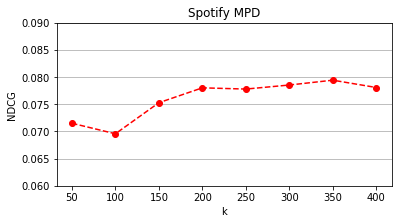

In [21]:
plt.figure(figsize=(6, 3))

ks = [50, 100, 150, 200, 250, 300, 350, 400]
kNdcgs = [0.071506, 0.069570, 0.075285, 0.078022, 0.077795, 0.078540, 0.079428, 0.078083]

plt.plot(ks, kNdcgs, "o--", color="red")
plt.xticks(ks)
plt.ylim(bottom=0.06, top=0.09)
plt.grid(True, axis="y")

plt.ylabel("NDCG")
plt.xlabel("k")
plt.title("Spotify MPD");

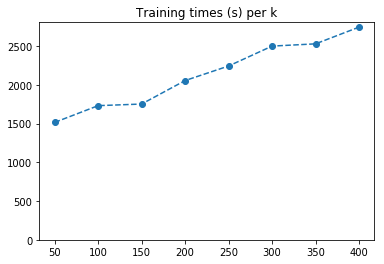

In [30]:
kTimes = [1516, 1732, 1753, 2056, 2244, 2501, 2530, 2746]

plt.plot(ks, kTimes, "o--")
plt.xticks(ks)
plt.ylim(bottom=0.0)

plt.title("Training times (s) per k");

In [ ]:
samplingCols = ["itemid", "albid", "artid",
                "", "itemid", "albid", "artid",
                "", "itemid", "albid", "artid"]
samplers = ["uniform", "uniform", "uniform",
            "exp", "exp", "exp", "exp",
            "crossbatch", "crossbatch", "crossbatch", "crossbatch"]
lrs = [0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1,
       1.0, 1.0, 1.0, 1.0]
maxIters = [100, 100, 100,
            100, 100, 100, 100,
            10, 10, 10, 10]

metadataPaths = [metadataPath, metadataPath, metadataPath,
                 metadataPathExp, metadataPathExp, metadataPathExp, metadataPathExp,
                 metadataPath, metadataPath, metadataPath, metadataPath]

for samplingCol, sampler, lr, maxIter, metadataPath in zip(
    samplingCols, samplers, lrs, maxIters, metadataPaths):
    
    fitStart = time.time()
    model = GlintFMPair(
        batchSize=256, stepSize=lr, linearReg=0.1, factorsReg=0.001, numDims=300,
        parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=maxIter,
        samplingCol=samplingCol, sampler=sampler, filterItemsCol="filteritemids",
        loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
    ).fit(trainFeatures)
    fitEnd = time.time()
    fitTime = fitEnd - fitStart

    hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
    model.destroy()
    print("{} {}:".format(sampler, samplingCol))
    print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# uniform itemid:
# 2484.56083s fit time
# 0.012000 hit rate
# 0.077789 NDCG
# uniform albid:
# 2261.73976s fit time
# 0.013000 hit rate
# 0.078428 NDCG
# uniform artid:
# 2228.59741s fit time
# 0.013000 hit rate
# 0.078954 NDCG

# exp :
# 3248.20180s fit time
# 0.009000 hit rate
# 0.085025 NDCG
# exp itemid:
# 2419.82472s fit time
# 0.009000 hit rate
# 0.084813 NDCG
# exp albid:
# 6692.71261s fit time
# 0.009000 hit rate
# 0.085049 NDCG

# crossbatch :
# 1473.46355s fit time
# 0.007000 hit rate
# 0.078983 NDCG
# crossbatch itemid:
# 1450.87150s fit time
# 0.008000 hit rate
# 0.080761 NDCG
# crossbatch albid:
# 1513.42223s fit time
# 0.010000 hit rate
# 0.082243 NDCG
# crossbatch artid:
# 1565.71061s fit time
# 0.011000 hit rate
# 0.082407 NDCG

In [23]:
fitStart = time.time()
model = GlintFMPair(
    batchSize=256, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=4, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

1254.15832s fit time
0.008000 hit rate
0.081026 NDCG


In [24]:
fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=4, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

1563.28630s fit time
0.010000 hit rate
0.086589 NDCG


In [20]:
fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=5, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

1606.61577s fit time
0.009000 hit rate
0.083519 NDCG


In [ ]:
samplingCols = ["", "itemid", "albid", "artid"]

for samplingCol in samplingCols:
    fitStart = time.time()
    model = GlintFMPair(
        batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
        parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
        samplingCol=samplingCol, sampler="crossbatch", filterItemsCol="filteritemids",
        loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
    ).fit(trainFeatures)
    fitEnd = time.time()
    fitTime = fitEnd - fitStart

    hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
    model.destroy()
    print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 1642.53664s fit time
# 0.010000 hit rate
# 0.083997 NDCG
# 1651.15506s fit time
# 0.009000 hit rate
# 0.084216 NDCG
# 1596.04214s fit time
# 0.008000 hit rate
# 0.083720 NDCG
# 1602.16093s fit time
# 0.010000 hit rate
# 0.083944 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["pid"], itemCols=["traid", "albid", "artid"], ctxitemCols=[])
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              userCols=["pid"], ctxitemCols=[])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-item.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 4388.87591s fit time
# 0.011000 hit rate
# 0.089265 NDCG

In [21]:
trainFeatures = toFeatures(trainData, encoderModels,       
                           allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                           itemCols=["traid", "albid", "artid"], ctxitemCols=[])
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"], ctxitemCols=[])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-item-name0125-10.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

4089.90604s fit time
0.013000 hit rate
0.089112 NDCG


In [ ]:
trainFeatures = toFeatures(trainData, encoderModels,       
                           allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid", "pyear"],
                           itemCols=["traid", "albid", "artid", "releaseid"], ctxitemCols=[]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid", "pyear"],
                              ctxitemCols=[])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-item-name-year.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 1477.09409s fit time
# 0.012000 hit rate
# 0.089227 NDCG

In [24]:
trainFeatures = toFeatures(trainData, encoderModels,       
                           allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                           itemCols=["traid", "albid", "artid", "releaseid"], ctxitemCols=[]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                              ctxitemCols=[])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-item-name-release.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

1525.40498s fit time
0.011000 hit rate
0.090719 NDCG


In [20]:
trainFeatures = toFeatures(trainData, encoderModels,       
                           allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                           itemCols=["traid", "albid", "artid", "releaseid",
                                     "danceabilityid", "energyid", "valenceid", "acousticnessid"],
                           ctxitemCols=[]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                              ctxitemCols=[])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-item-name-release-music1.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

1502.16055s fit time
0.010000 hit rate
0.089899 NDCG


In [24]:
trainFeatures = toFeatures(trainData, encoderModels,       
                           allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                           itemCols=["traid", "albid", "artid", "releaseid",
                                     "keyid", "loudnessid", "modeid", "tempoid"],
                           ctxitemCols=[]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                              ctxitemCols=[])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-item-name-release-music2.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

2721.11135s fit time
0.009000 hit rate
0.088851 NDCG


In [ ]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["pid"], itemCols=["traid"], ctxitemCols=["prev_traid"])
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              userCols=["pid"], ctxitemCols=["prev_traid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-prev.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 3000.97390s fit time
# 0.036000 hit rate
# 0.123655 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["pid"], itemCols=["traid", "albid", "artid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              userCols=["pid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-prev-item.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 2396.39066s fit time
# 0.030000 hit rate
# 0.131917 NDCG

In [20]:
trainFeatures = toFeatures(trainData, encoderModels,
                           allUserNameWeights=[0.125], userNameCols=["pname"],
                           userCols=["pid"], itemCols=["traid", "albid", "artid", "releaseid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

3007.79344s fit time
0.033000 hit rate
0.132544 NDCG


In [ ]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           userCols=["pid"], itemCols=["traid"], ctxitemCols=["prev_traid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, sharedItemFeatures=True,
                              queryctxData=valData,
                              userCols=["pid"], ctxitemCols=["prev_traid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


modelPath = "MPD-trans-prev.model"
metadataPath = "MPD-trans-prev.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 1531.65764s fit time
# 0.040000 hit rate
# 0.131463 NDCG

In [ ]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           userCols=["pid"], itemCols=["traid", "albid", "artid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              userCols=["pid"], sharedItemFeatures=True,
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))

metadataPath = "MPD-trans-prev-item.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 1735.86304s fit time
# 0.037000 hit rate
# 0.140176 NDCG

In [21]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           allUserNameWeights=[0.125], userNameCols=["pname"],
                           userCols=["pid"], itemCols=["traid", "albid", "artid", "releaseid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-trans-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

2189.88675s fit time
0.039000 hit rate
0.140461 NDCG


In [20]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           allUserNameWeights=[0.125], userNameCols=["pname"],
                           userCols=["pid"], itemCols=["traid", "albid", "artid", "releaseid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-trans-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

2232.94610s fit time
0.043000 hit rate
0.143323 NDCG


In [20]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           allUserNameWeights=[0.125], userNameCols=["pname"],
                           coldStartUserCols=["traid"],
                           userCols=[], itemCols=["traid", "albid", "artid", "releaseid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], coldStartUserCols=["traid"], userCols=[],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-cold-trans-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

5385.25767s fit time
0.037000 hit rate
0.139278 NDCG


In [ ]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           allUserNameWeights=[0.125], userNameCols=["pname"],
                           userColdStartWeighting="equi",
                           coldStartUserCols=["traid"],
                           userCols=[], itemCols=["traid", "albid", "artid", "releaseid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"],
                              userColdStartWeighting="equi",
                              coldStartUserCols=["traid"], userCols=[],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-cold-trans-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

# 0.133758 NDCG

In [20]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           allUserNameWeights=[0.125], userNameCols=["pname"],
                           userColdStartWeighting="one",
                           coldStartUserCols=["traid"],
                           userCols=[], itemCols=["traid", "albid", "artid", "releaseid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], coldStartUserCols=["traid"], userCols=[],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-cold-trans-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

6418.01548s fit time
0.000000 hit rate
0.000000 NDCG


## Final evaluation

In [35]:
fitStart = time.time()
model = PopRank(filterUserItems=True).fit(trainData.select(col("pid").alias("userid"), col("traid").alias("itemid")))
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
hitRate, ndcg, popRankHitRates = evaluateModel(
    valSeedsData.select(col("pid").alias("userid"), col("traid").alias("itemid")),
    valData.select(col("pid").alias("userid"), col("traid").alias("itemid")),
    model, withHitRates=True)
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

0.10198s fit time
0.001000 hit rate
0.019462 NDCG


In [36]:
fitStart = time.time()
model = SAGH(filterUserItems=True).fit(
    trainData.select(col("pid").alias("userid"), col("traid").alias("itemid"), "artid"))
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
hitRate, ndcg, saghHitRates = evaluateModel(
    valSeedsData.select(col("pid").alias("userid"), col("traid").alias("itemid"), "artid"),
    valData.select(col("pid").alias("userid"), col("traid").alias("itemid")),
    model, withHitRates=True)
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

0.09328s fit time
0.008000 hit rate
0.049862 NDCG


In [29]:
ks = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000]
for k in ks:
    hitRate, ndcg = evaluateModel(
        valSeedsData.select(col("pid").alias("userid"), col("traid").alias("itemid")),
        valData.select(col("pid").alias("userid"), col("traid").alias("itemid")),
        KNN(filterUserItems=True, k=k),
        traindata=trainData.select(col("pid").alias("userid"), col("traid").alias("itemid")))
    print("{} k\n{:.6f} hit rate\n{:.6f} NDCG".format(k, hitRate, ndcg))

10 k
0.010000 hit rate
0.082170 NDCG
50 k
0.015000 hit rate
0.099304 NDCG
100 k
0.017000 hit rate
0.101515 NDCG
150 k
0.014000 hit rate
0.098603 NDCG
200 k
0.015000 hit rate
0.098978 NDCG
250 k
0.017000 hit rate
0.100175 NDCG
300 k
0.017000 hit rate
0.099544 NDCG
350 k
0.015000 hit rate
0.098489 NDCG
400 k
0.015000 hit rate
0.097493 NDCG
450 k
0.015000 hit rate
0.097460 NDCG
500 k
0.013000 hit rate
0.096539 NDCG
1000 k
0.011000 hit rate
0.093401 NDCG


In [33]:
hitRate, ndcg, kHitRates = evaluateModel(
    valSeedsData.select(col("pid").alias("userid"), col("traid").alias("itemid"), "artid"),
    valData.select(col("pid").alias("userid"), col("traid").alias("itemid")),
    KNN(filterUserItems=True, k=100), withHitRates=True,
    traindata=trainData.select(col("pid").alias("userid"), col("traid").alias("itemid")))
print("{:.6f} hit rate\n{:.6f} NDCG".format(hitRate, ndcg))

0.014000 hit rate
0.081457 NDCG


In [22]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["pid"], itemCols=["traid"], ctxitemCols=[])
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              userCols=["pid"], ctxitemCols=[])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-final.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg, hitRates = evaluateModel(valqueryFeatures, valFeatures, model, withHitRates=True)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

with open("MPD-final-hitRates.pickle", "wb") as f:
    pickle.dump(hitRates, f)

1203.41381s fit time
0.006000 hit rate
0.070129 NDCG


In [20]:
trainFeatures = toFeatures(trainData, encoderModels,
                           userCols=["pid"], itemCols=["traid"], ctxitemCols=[])
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valData,
                              userCols=["pid"], ctxitemCols=[])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-final.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=1.0, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg, hitRates = evaluateModel(valqueryFeatures, valFeatures, model, withHitRates=True)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

with open("MPD-final-hitRates.pickle", "wb") as f:
    pickle.dump(hitRates, f)

12477.29742s fit time
0.005000 hit rate
0.072082 NDCG


In [20]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           allUserNameWeights=[0.125], userNameCols=["pname"],
                           userCols=["pid"], itemCols=["traid", "albid", "artid", "releaseid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-final-trans-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg = evaluateModel(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))

17809.19791s fit time
0.032000 hit rate
0.122871 NDCG


In [20]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           allUserNameWeights=[0.125], userNameCols=["pname"],
                           userCols=["pid"], itemCols=["traid", "albid", "artid", "releaseid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], userCols=["pid"],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-final-trans-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

hitRate, ndcg, hitRates = evaluateModel(valqueryFeatures, valFeatures, model, withHitRates=True)
print("{:.5f}s fit time\n{:.6f} hit rate\n{:.6f} NDCG".format(fitTime, hitRate, ndcg))
with open("MPD-final-prev-all-hitRates.pickle", "wb") as f:
    pickle.dump(hitRates, f)
    
model.destroy(terminateOtherClients=True)

12449.02096s fit time
0.032000 hit rate
0.124586 NDCG


In [ ]:
with open("MPD-final-hitRates.pickle", "rb") as f:
    hitRates = pickle.load(f)

with open("MPD-final-prev-all-hitRates.pickle", "rb") as f:
    hitRates2 = pickle.load(f)

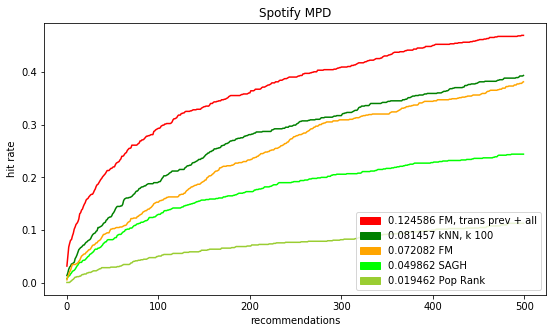

In [45]:
plt.figure(figsize=(9, 5))
plt.plot(popRankHitRates, color="yellowgreen")
plt.plot(saghHitRates, color="lime")
plt.plot(kHitRates, color="green")
plt.plot(hitRates, color="orange")
plt.plot(hitRates2, color="red")

yellowgreen_patch = mpatches.Patch(color="yellowgreen",
                                   label="0.019462 Pop Rank")
green_patch = mpatches.Patch(color="lime",
                             label="0.049862 SAGH")
dgreen_patch = mpatches.Patch(color="green",
                              label="0.081457 kNN, k 100")
orange_patch = mpatches.Patch(color="orange",
                              label="0.072082 FM")
red_patch = mpatches.Patch(color="red",
                           label="0.124586 FM, trans prev + all")
patches = [red_patch, dgreen_patch, orange_patch,
           green_patch, yellowgreen_patch]
plt.legend(handles=patches, loc="lower right")

plt.ylabel("hit rate")
plt.xlabel("recommendations")
plt.title("Spotify MPD")

plt.savefig("MPD-baselines.png", bbox_inches="tight");

## Final cold-start evaluation

In [23]:
fitStart = time.time()
model = PopRank(filterUserItems=True).fit(trainData.select(col("pid").alias("userid"), col("traid").alias("itemid")))
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
ndcg, popRankHitRates = evaluateModelMulti(
    valSeedsData.select(col("pid").alias("userid"), col("traid").alias("itemid")),
    valData.select(col("pid").alias("userid"), col("traid").alias("itemid")),
    model, withHitRates=True)
print("{:.5f}s fit time\n{:.6f} NDCG".format(fitTime, ndcg))

0.23967s fit time
0.079953 NDCG


In [24]:
fitStart = time.time()
model = SAGH(filterUserItems=True).fit(
    trainData.select(col("pid").alias("userid"), col("traid").alias("itemid"), "artid"))
fitEnd = time.time()
fitTime = fitEnd - fitStart
            
ndcg, saghHitRates = evaluateModelMulti(
    valSeedsData.select(col("pid").alias("userid"), col("traid").alias("itemid"), "artid"),
    valData.select(col("pid").alias("userid"), col("traid").alias("itemid")),
    model, withHitRates=True)
print("{:.5f}s fit time\n{:.6f} NDCG".format(fitTime, ndcg))

0.09313s fit time
0.096829 NDCG


In [25]:
ndcg, kHitRates = evaluateModelMulti(
    valSeedsData.select(col("pid").alias("userid"), col("traid").alias("itemid")),
    valData.select(col("pid").alias("userid"), col("traid").alias("itemid")),
    KNN(filterUserItems=True, k=100), withHitRates=True,
    traindata=trainData.select(col("pid").alias("userid"), col("traid").alias("itemid")))
print("{:.6f} NDCG".format(ndcg))

0.307606 NDCG


In [21]:
trainFeatures = toFeatures(trainData, encoderModels,
                           coldStartUserCols=["traid"],
                           userCols=[], itemCols=["traid"], ctxitemCols=[]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valCtxData,
                              coldStartUserCols=["traid"],
                              userCols=[], ctxitemCols=[])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-final-seeds2.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

ndcg = evaluateModelMulti(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} NDCG".format(fitTime, ndcg))

4645.22943s fit time
0.168570 NDCG


In [ ]:
trainFeatures = toFeatures(trainData, encoderModels,
                           coldStartUserCols=["traid"],
                           userCols=[], itemCols=["traid"], ctxitemCols=[]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, 
                              queryctxData=valCtxData,
                              coldStartUserCols=["traid"],
                              userCols=[], ctxitemCols=[])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-final-seeds2.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

ndcg = evaluateModelMulti(valqueryFeatures, valFeatures, model)
model.destroy()
print("{:.5f}s fit time\n{:.6f} NDCG".format(fitTime, ndcg))

with open("MPD-final-seeds-hitRates.pickle", "wb") as f:
    pickle.dump(hitRates, f)

# 57678.36900s fit time
# 0.184790 NDCG

In [20]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           allUserNameWeights=[0.125], userNameCols=["pname"],
                           coldStartUserCols=["traid"],
                           userCols=[], itemCols=["traid", "albid", "artid", "releaseid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valCtxData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], coldStartUserCols=["traid"], userCols=[],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-final-seeds-trans-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=10,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

ndcg, hitRates = evaluateModelMulti(valqueryFeatures, valFeatures, model, withHitRates=True)
model.destroy()
print("{:.5f}s fit time\n{:.6f} NDCG".format(fitTime, ndcg))

with open("MPD-final-seeds-trans-prev-all-hitRates.pickle", "wb") as f:
    pickle.dump(hitRates, f)

6202.73424s fit time
0.240857 NDCG


In [ ]:
trainFeatures = toFeatures(trainData, encoderModels, sharedItemFeatures=True,
                           allUserNameWeights=[0.125], userNameCols=["pname"],
                           coldStartUserCols=["traid"],
                           userCols=[], itemCols=["traid", "albid", "artid", "releaseid"],
                           ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"]).coalesce(400).cache()
valqueryFeatures = toFeatures(valSeedsData, encoderModels, sharedItemFeatures=True, 
                              queryctxData=valCtxData,
                              allUserNameWeights=[0.125], userNameCols=["pname"], coldStartUserCols=["traid"], userCols=[],
                              ctxitemCols=["prev_traid", "prev_albid", "prev_artid", "prev_releaseid"])
valFeatures = valData.select(col("pid").alias("userid"), col("traid").alias("itemid"))


metadataPath = "MPD-final-seeds-trans-prev-all.meta"

fitStart = time.time()
model = GlintFMPair(
    batchSize=1024, stepSize=0.6, linearReg=0.1, factorsReg=0.001, numDims=300,
    parameterServerHost=parameterServerHost, numParameterServers=3, maxIter=100,
    samplingCol="", sampler="crossbatch", filterItemsCol="filteritemids",
    loadMetadata=True, saveMetadata=True, metadataPath=metadataPath
).fit(trainFeatures)
fitEnd = time.time()
fitTime = fitEnd - fitStart

ndcg, hitRates = evaluateModelMulti(valqueryFeatures, valFeatures, model, withHitRates=True)
model.destroy()
print("{:.5f}s fit time\n{:.6f} NDCG".format(fitTime, ndcg))

with open("MPD-final-seeds-trans-prev-all-hitRates.pickle", "wb") as f:
    pickle.dump(hitRates, f)
    
# 53675.63951s fit time
# 0.255734 NDCG

In [27]:
with open("MPD-final-seeds-hitRates.pickle", "rb") as f:
    hitRates = pickle.load(f)

with open("MPD-final-seeds-trans-prev-all-hitRates.pickle", "rb") as f:
    hitRates2 = pickle.load(f)

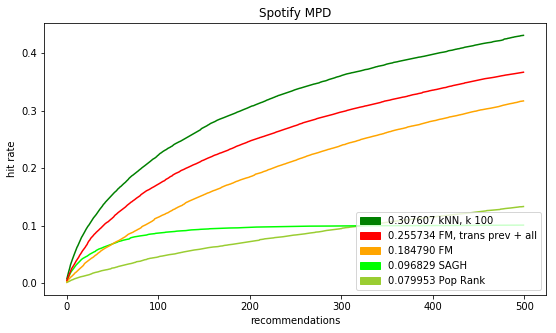

In [29]:
plt.figure(figsize=(9, 5))
plt.plot(popRankHitRates, color="yellowgreen")
plt.plot(saghHitRates, color="lime")
plt.plot(kHitRates, color="green")
plt.plot(hitRates, color="orange")
plt.plot(hitRates2, color="red")

yellowgreen_patch = mpatches.Patch(color="yellowgreen",
                                   label="0.079953 Pop Rank")
green_patch = mpatches.Patch(color="lime",
                             label="0.096829 SAGH")
dgreen_patch = mpatches.Patch(color="green",
                              label="0.307607 kNN, k 100")
orange_patch = mpatches.Patch(color="orange",
                              label="0.184790 FM")
red_patch = mpatches.Patch(color="red",
                           label="0.255734 FM, trans prev + all")
patches = [dgreen_patch, red_patch, orange_patch,
           green_patch, yellowgreen_patch]
plt.legend(handles=patches, loc="lower right")

plt.ylabel("hit rate")
plt.xlabel("recommendations")
plt.title("Spotify MPD")

plt.savefig("MPD-cold-baselines.png", bbox_inches="tight");